In [32]:
import statsmodels
statsmodels.__version__

'0.12.2'

In [33]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [34]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [35]:
data = pd.read_csv("/content/gdrive/My Drive/monthly-car-sales.csv")
data['Month'] = pd.to_datetime(data['Month'], infer_datetime_format=True)
indexedDataset = data.set_index(['Month'])

In [36]:
# summarize shape
print(indexedDataset.shape)
# show first few rows
print(indexedDataset.head())

(108, 1)
            Sales
Month            
1960-01-01   6550
1960-02-01   8728
1960-03-01  12026
1960-04-01  14395
1960-05-01  14587


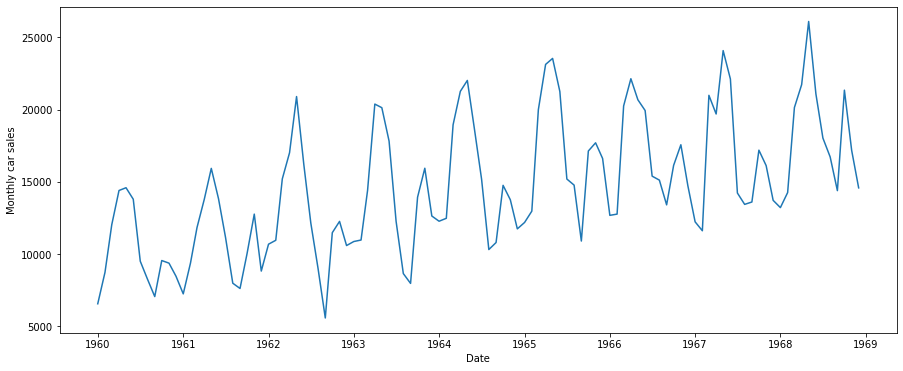

In [37]:
## plot graph
plt.xlabel("Date")
plt.ylabel("Monthly car sales")
plt.plot(indexedDataset)

The time series doesn't look stationary

In [38]:
# Determining rolling statistics

rollmean = indexedDataset.rolling(window=12).mean()
rollstd = indexedDataset.rolling(window=12).std()

print(rollmean, rollstd)

                   Sales
Month                   
1960-01-01           NaN
1960-02-01           NaN
1960-03-01           NaN
1960-04-01           NaN
1960-05-01           NaN
...                  ...
1968-08-01  17655.916667
1968-09-01  17721.500000
1968-10-01  18067.750000
1968-11-01  18156.166667
1968-12-01  18228.166667

[108 rows x 1 columns]                   Sales
Month                  
1960-01-01          NaN
1960-02-01          NaN
1960-03-01          NaN
1960-04-01          NaN
1960-05-01          NaN
...                 ...
1968-08-01  3962.588077
1968-09-01  3895.262169
1968-10-01  4025.909296
1968-11-01  3990.717248
1968-12-01  3910.249488

[108 rows x 1 columns]


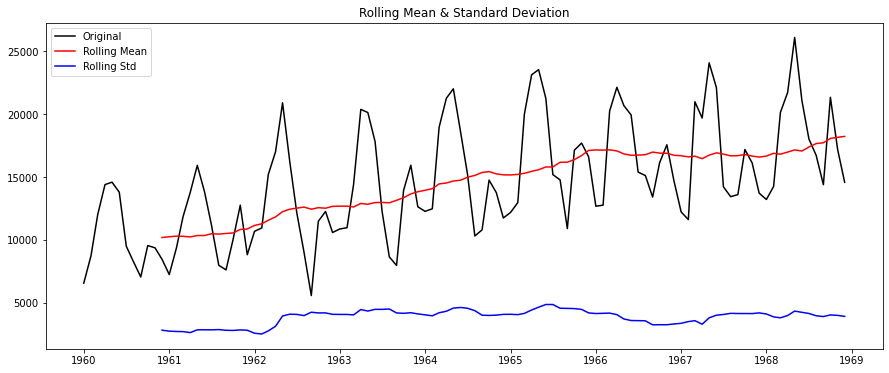

In [39]:
# Plot rolling statistics

orig = plt.plot(indexedDataset, color="black", label = "Original")
mean = plt.plot(rollmean, color="red", label = "Rolling Mean")
std = plt.plot(rollstd, color="blue", label = "Rolling Std")
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [40]:
def test_stationarity(timeseries, column=None):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean() 
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='black',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='blue', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    if column:
      dftest = adfuller(timeseries[column], autolag='AIC')
    else:
      dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

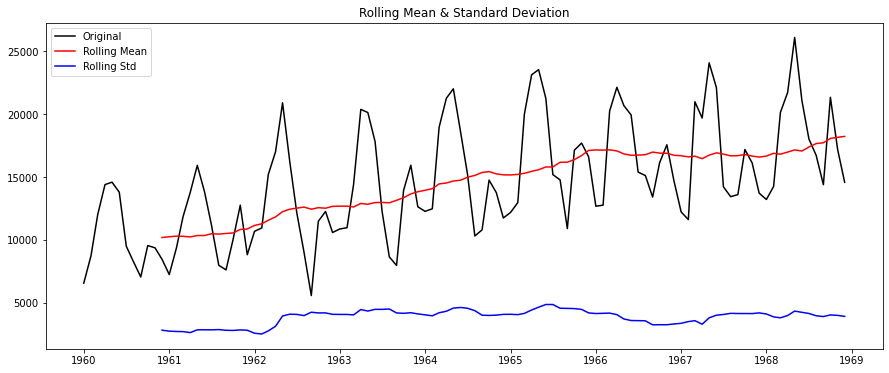

Results of Dickey-Fuller Test:
Test Statistic                 -1.223813
p-value                         0.663269
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


In [41]:
test_stationarity(indexedDataset, "Sales")
# Not stationary

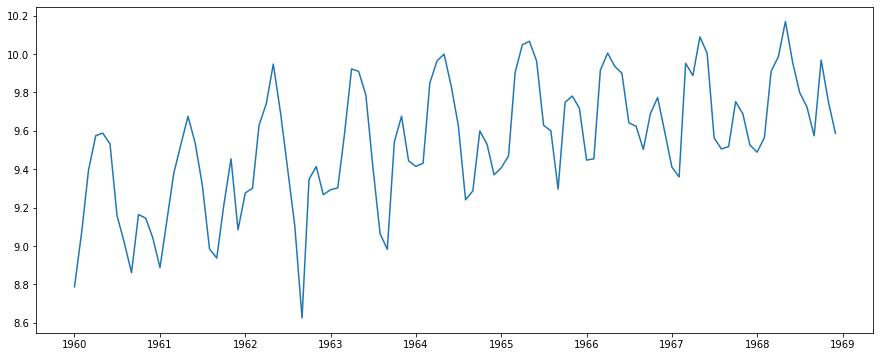

In [42]:
# Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

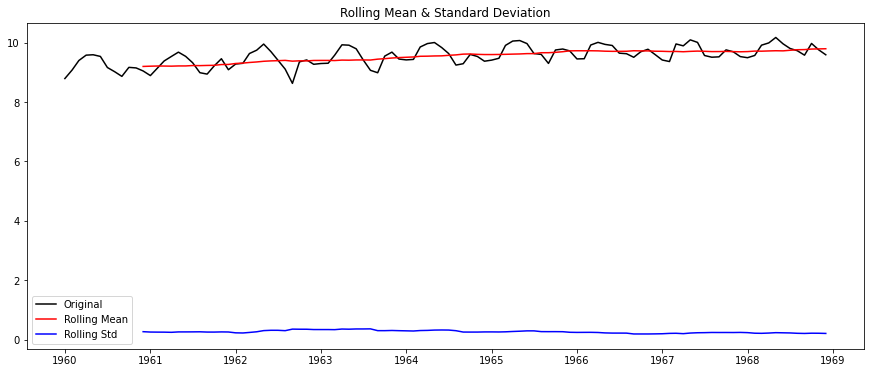

Results of Dickey-Fuller Test:
Test Statistic                 -1.452425
p-value                         0.556901
#Lags Used                     13.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [43]:
test_stationarity(indexedDataset_logScale, "Sales")
#Better Mean: looks stationary

#Determing rolling statistics
movingaverage = indexedDataset_logScale.rolling(window=12).mean() 
movingstd = indexedDataset_logScale.rolling(window=12).std()

In [44]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingaverage
datasetLogScaleMinusMovingAverage.head(12)

datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(12)



,Sales
Month,
1960-12-01,-0.152304
1961-01-01,-0.316286
1961-02-01,-0.063503
1961-03-01,0.171108
1961-04-01,0.327000
1961-05-01,0.464126
1961-06-01,0.322181
1961-07-01,0.093493
1961-08-01,-0.238172


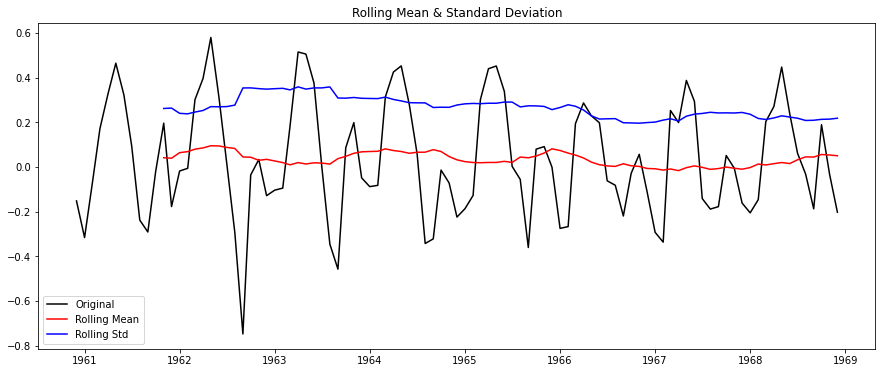

Results of Dickey-Fuller Test:
Test Statistic                 -2.023542
p-value                         0.276347
#Lags Used                     12.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


In [45]:
test_stationarity(datasetLogScaleMinusMovingAverage, "Sales")

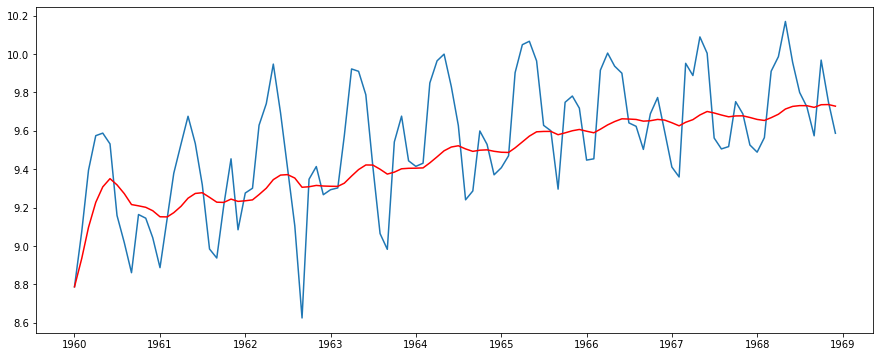

In [46]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color="red")

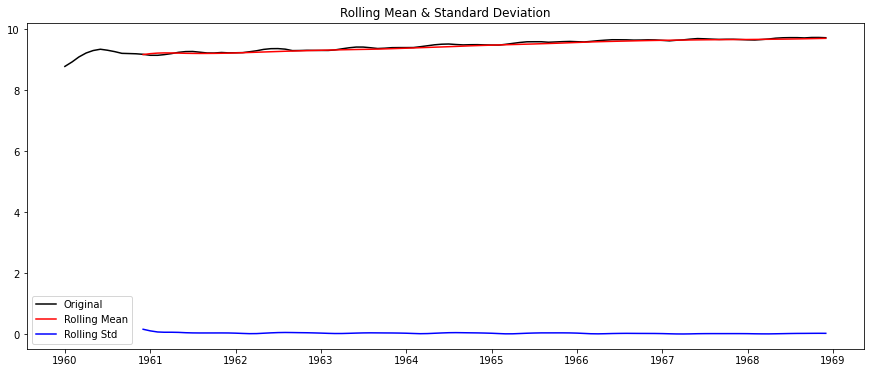

Results of Dickey-Fuller Test:
Test Statistic                 -1.449422
p-value                         0.558367
#Lags Used                     13.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [47]:
test_stationarity(exponentialDecayWeightedAverage, "Sales")

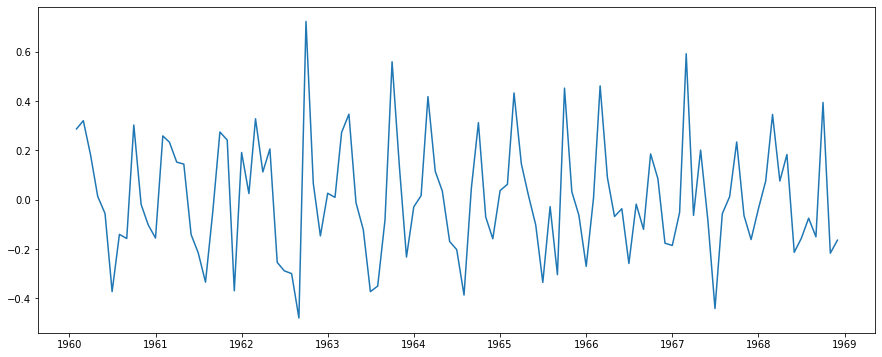

In [58]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

# datasetDiffShifting = indexedDataset - indexedDataset.shift()
# plt.plot(datasetDiffShifting)

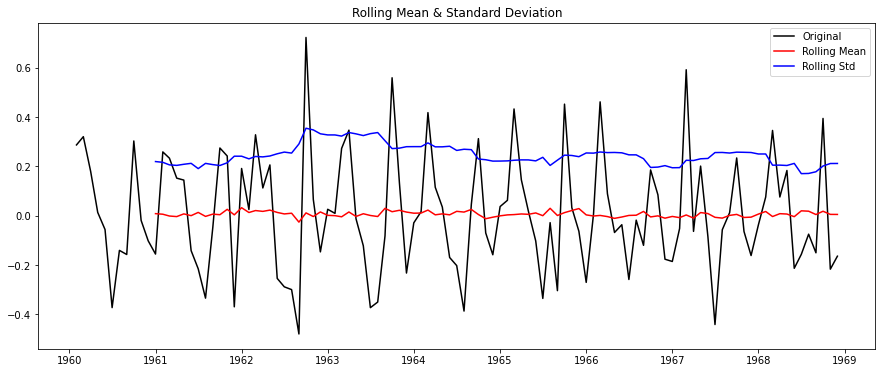

Results of Dickey-Fuller Test:
Test Statistic                 -4.193835
p-value                         0.000675
#Lags Used                     12.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [49]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting, "Sales")

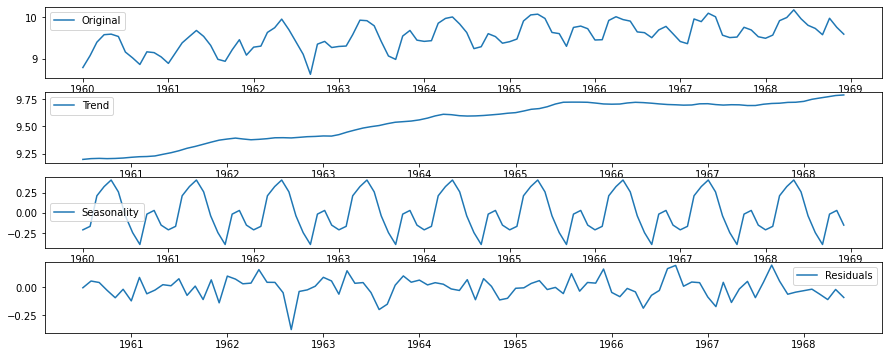

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts_components = seasonal_decompose(indexedDataset_logScale)

trend = ts_components.trend
seasonal = ts_components.seasonal
residual = ts_components.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label="Original")
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal, label="Seasonality")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(residual, label="Residuals")
plt.legend(loc="best")

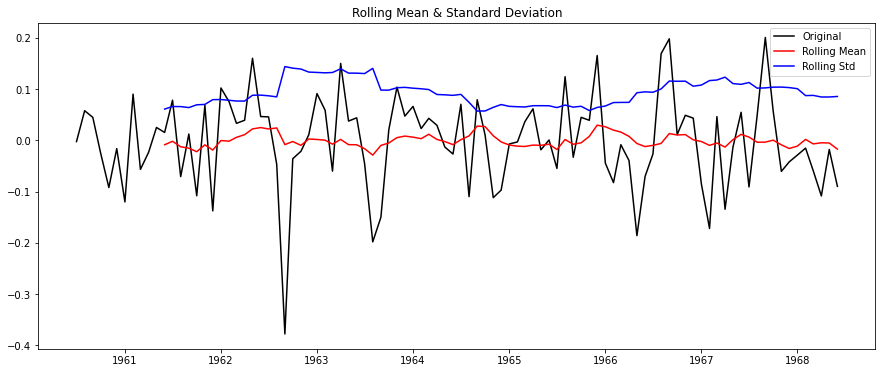

Results of Dickey-Fuller Test:
Test Statistic                 -3.970430
p-value                         0.001574
#Lags Used                     10.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


In [60]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

/root/.local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


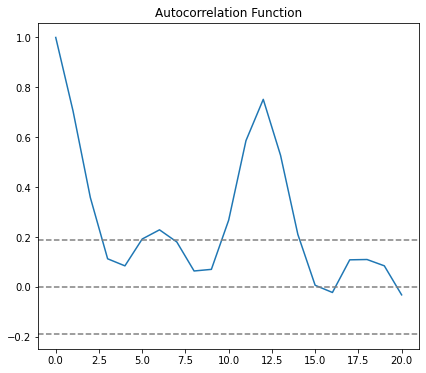

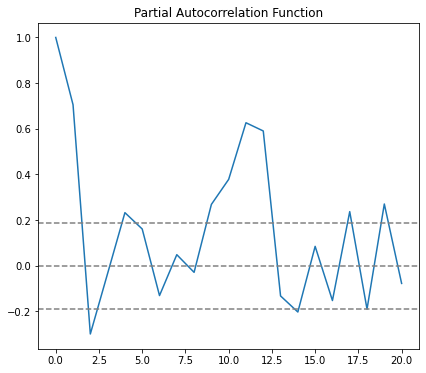

In [68]:
# Value of p and q
# p -> pacf
# q -> acf
lag_acf = acf(indexedDataset_logScale, nlags=20)
lag_pacf = pacf(indexedDataset_logScale, nlags=20, method='ols')

#plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(indexedDataset_logScale)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(indexedDataset_logScale)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

#plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(indexedDataset_logScale)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(indexedDataset_logScale)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

108

/root/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/root/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/root/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/root/.local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Plotting AR model


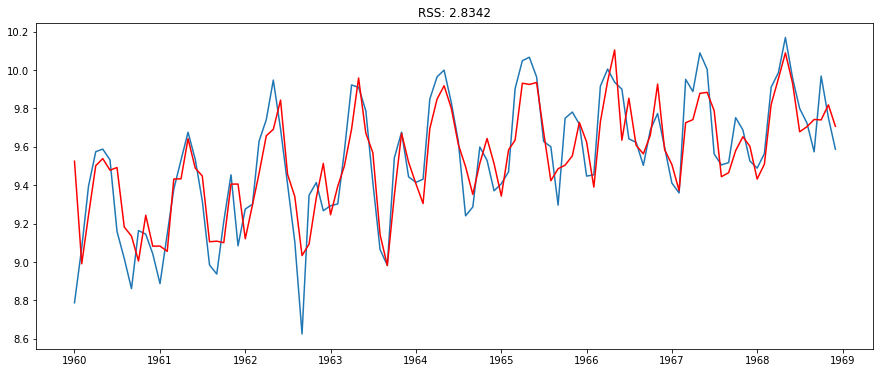

In [88]:
# ARIMA Model
#datasetLogDiffShifting = datasetLogDiffShifting.resample("M").last()

model=ARIMA(indexedDataset_logScale, order=(3,0,15))
results_AR=model.fit()
plt.plot(indexedDataset_logScale)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-indexedDataset_logScale["Sales"])**2))
print("Plotting AR model")


In [128]:
pred = np.round(np.exp(results_AR.fittedvalues),0).reset_index(name="PredictedSales")

In [129]:
actual = indexedDataset.reset_index()

In [130]:
actual.merge(pred, on="Month", how="inner")

,Month,Sales,PredictedSales
0,1960-01-01,6550,13693.0
1,1960-02-01,8728,8027.0
2,1960-03-01,12026,10335.0
3,1960-04-01,14395,13382.0
4,1960-05-01,14587,13884.0
...,...,...,...
103,1968-08-01,16722,16391.0
104,1968-09-01,14385,17023.0
105,1968-10-01,21342,16986.0
106,1968-11-01,17180,18369.0


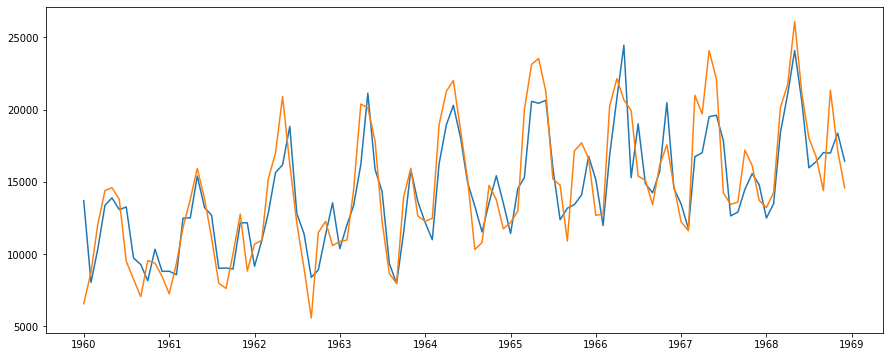

In [134]:
plt.plot(np.exp(results_AR.fittedvalues))
plt.plot(indexedDataset)